In [1]:
import requests
import pandas as pd
import lxml.etree as ET
from bs4 import BeautifulSoup as soup
import unicodedata
import tqdm
from time import sleep
import time

In [125]:
df_all = pd.read_hdf("pandemie_titeldaten.h5", key="df")
df_all

,idn,title,date,lang,urn
0,1285990005,"2020 Das Jahr, das die Welt veränderte Der ame...",2024,ger,N/A
1,1317002237,Ängste der Allgemeinbevölkerung in Zeiten der ...,2024,ger,urn:nbn:de:bsz:14-qucosa2-890970
2,1319076106,Aufbau eines Key Account Managements in der To...,2024,ger,urn:nbn:de:101:1-2024021302301350289147
3,1319076114,Aufbau eines Key Account Managements in der To...,2024,ger,urn:nbn:de:101:1-2024021302302274697630
4,1315575361,Auswirkungen der Corona-Pandemie auf die Ausbi...,2024,ger,urn:nbn:de:101:1-2024011102383134159187
...,...,...,...,...,...
11363,129882589X,"Zwei Nachbarländer, eine Pandemie",2023,ger,urn:nbn:de:101:1-2023080821170040558967
11364,1232892661,Zwei Runden gehen an Corona – aber die Urologi...,2021,ger,urn:nbn:de:101:1-2021050520504432857162
11365,1307057543,Zwischen Arbeitserleichterung und De-Professio...,2023,ger,urn:nbn:de:101:1-2023102409011131884864
11366,1241532591,Zwischen Pandemie und Wahlkampf: Verhältnismäß...,2021,ger,urn:nbn:de:101:1-2021092021390437649681


### Optional: Einschränken des Sets auf deutschsprachige Publikationen: 

In [126]:
df = df_all.loc[df_all.lang == "ger"]
df

,idn,title,date,lang,urn
0,1285990005,"2020 Das Jahr, das die Welt veränderte Der ame...",2024,ger,N/A
1,1317002237,Ängste der Allgemeinbevölkerung in Zeiten der ...,2024,ger,urn:nbn:de:bsz:14-qucosa2-890970
2,1319076106,Aufbau eines Key Account Managements in der To...,2024,ger,urn:nbn:de:101:1-2024021302301350289147
3,1319076114,Aufbau eines Key Account Managements in der To...,2024,ger,urn:nbn:de:101:1-2024021302302274697630
4,1315575361,Auswirkungen der Corona-Pandemie auf die Ausbi...,2024,ger,urn:nbn:de:101:1-2024011102383134159187
...,...,...,...,...,...
11363,129882589X,"Zwei Nachbarländer, eine Pandemie",2023,ger,urn:nbn:de:101:1-2023080821170040558967
11364,1232892661,Zwei Runden gehen an Corona – aber die Urologi...,2021,ger,urn:nbn:de:101:1-2021050520504432857162
11365,1307057543,Zwischen Arbeitserleichterung und De-Professio...,2023,ger,urn:nbn:de:101:1-2023102409011131884864
11366,1241532591,Zwischen Pandemie und Wahlkampf: Verhältnismäß...,2021,ger,urn:nbn:de:101:1-2021092021390437649681


### Optional: Kleinschreibung

In [127]:
df.loc[:, 'title'] = df['title'].str.lower() 

## Entfernung von "Stopwords": 

In [135]:
#Importieren der zu entfernenden Stopwörter (wie bpsw. "und", "der", etc.):

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')

stopger = stopwords.words('german')

newStopwords = [':', '[', ']', '–', ',', '.']
stopger.extend(newStopwords)

In [152]:
#Entfernung aller überflüssigen Leerzeichen:
df.loc[:, 'title_clean'] = df['title'].str.replace(r'\s+', ' ', regex=True)
df.loc[:, 'title_clean'] = df['title_clean'].str.replace(r'(\w+)[,:!\[\]]', r'\1', regex=True)

#Abgleich der Wörter mit den Stopwörtern - Stopwerds werden ausgeschlossen: 
df.loc[:, 'title_clean'] = df['title_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopger]))

df

,idn,title,date,lang,urn,title_clean
0,1285990005,"2020 das jahr, das die welt veränderte der ame...",2024,ger,N/A,2020 jahr welt veränderte amerikanische soziol...
1,1317002237,ängste der allgemeinbevölkerung in zeiten der ...,2024,ger,urn:nbn:de:bsz:14-qucosa2-890970,ängste allgemeinbevölkerung zeiten covid-19-pa...
2,1319076106,aufbau eines key account managements in der to...,2024,ger,urn:nbn:de:101:1-2024021302301350289147,aufbau key account managements tourismusbranch...
4,1315575361,auswirkungen der corona-pandemie auf die ausbi...,2024,ger,urn:nbn:de:101:1-2024011102383134159187,auswirkungen corona-pandemie ausbildung gesund...
5,131701071X,auswirkungen der covid-19-pandemie auf die pri...,2024,ger,urn:nbn:de:bsz:16-heidok-342525,auswirkungen covid-19-pandemie primärversorgun...
...,...,...,...,...,...,...
11363,129882589X,"zwei nachbarländer, eine pandemie",2023,ger,urn:nbn:de:101:1-2023080821170040558967,zwei nachbarländer pandemie
11364,1232892661,zwei runden gehen an corona – aber die urologi...,2021,ger,urn:nbn:de:101:1-2021050520504432857162,zwei runden gehen corona urologie ende gewinnen
11365,1307057543,zwischen arbeitserleichterung und de-professio...,2023,ger,urn:nbn:de:101:1-2023102409011131884864,arbeitserleichterung de-professionalisierungsg...
11366,1241532591,zwischen pandemie und wahlkampf: verhältnismäß...,2021,ger,urn:nbn:de:101:1-2021092021390437649681,pandemie wahlkampf verhältnismäßigkeit wahren


## Näherer Eindruck der Titel - ggf. weitere Bereinigung: 

In [153]:
print(df.title_clean)

0        2020 jahr welt veränderte amerikanische soziol...
1        ängste allgemeinbevölkerung zeiten covid-19-pa...
2        aufbau key account managements tourismusbranch...
4        auswirkungen corona-pandemie ausbildung gesund...
5        auswirkungen covid-19-pandemie primärversorgun...
                               ...                        
11363                          zwei nachbarländer pandemie
11364      zwei runden gehen corona urologie ende gewinnen
11365    arbeitserleichterung de-professionalisierungsg...
11366        pandemie wahlkampf verhältnismäßigkeit wahren
11367                                       zwischenbilanz
Name: title_clean, Length: 8100, dtype: object


In [154]:
df = df.drop_duplicates(subset='title', keep='first')

In [155]:
print(df.title_clean)

0        2020 jahr welt veränderte amerikanische soziol...
1        ängste allgemeinbevölkerung zeiten covid-19-pa...
2        aufbau key account managements tourismusbranch...
4        auswirkungen corona-pandemie ausbildung gesund...
5        auswirkungen covid-19-pandemie primärversorgun...
                               ...                        
11363                          zwei nachbarländer pandemie
11364      zwei runden gehen corona urologie ende gewinnen
11365    arbeitserleichterung de-professionalisierungsg...
11366        pandemie wahlkampf verhältnismäßigkeit wahren
11367                                       zwischenbilanz
Name: title_clean, Length: 8100, dtype: object


## Ein erster Eindruck (Verteilung nach Jahreszahlen):


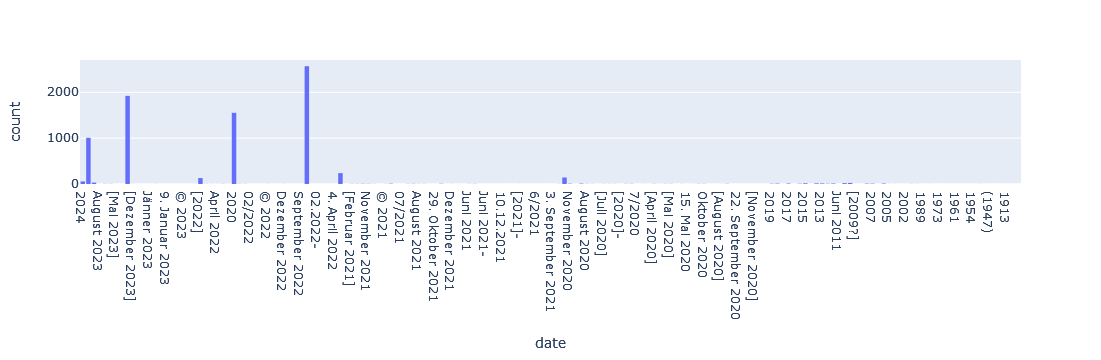

In [156]:
#Mit der Bibliothek plotly können interaktive Graphen geplottet werden:
import plotly.express as px

fig1 = px.histogram(df, x='date') #Mit px.bar() wird jede Zeile des übergebenen DataFrames in Form eines Balken dargestellt. Die Notation wird wie folgt übergeben: dataframe, x-Achse, y-Achse.
fig1.show() #Mit der Funktion .show() wird der fertige Graph angezeigt.


In [157]:
df.query("date.str.len() > 4")

,idn,title,date,lang,urn,title_clean
75,1296729192,30 bremer künstler:innen in zeiten der pandemie,[2023],ger,N/A,30 bremer künstlerinnen zeiten pandemie
85,1303562898,akte 8: pandemie roman,August 2023,ger,N/A,akte 8 pandemie roman
92,1287957811,"angst, politik, zivilcourage rückschau auf die...",[2023],ger,N/A,angst politik zivilcourage rückschau corona-krise
138,1290323593,auswirkungen der covid-19-pandemie auf österre...,[2023],ger,N/A,auswirkungen covid-19-pandemie österreichs gem...
141,1266212353,auswirkungen von covid-19 auf die wirtschaft e...,[2023],ger,N/A,auswirkungen covid-19 wirtschaft maschinen-gen...
...,...,...,...,...,...,...
9594,989614123,themenkompass ... pandemie,2007-2009,ger,N/A,themenkompass ... pandemie
9626,017811171,braegen zeitschrift für graphomanie und pandemie,1989-1989,ger,N/A,braegen zeitschrift graphomanie pandemie
9627,1015712908,saegen zeitschrift für graphomanie und pandemie,1989-1989,ger,N/A,saegen zeitschrift graphomanie pandemie
9640,480824428,die geschichte der cholera bis zum ende der ...,[1951],ger,N/A,die geschichte cholera ende ersten pandemie ...


OK, more datacleaning first... :

In [158]:
df['date'] = df['date'].str.replace(r'[\[\]\(\)?]', '', regex=True)

In [159]:
df.query("date.str.len() > 4")

,idn,title,date,lang,urn,title_clean
85,1303562898,akte 8: pandemie roman,August 2023,ger,N/A,akte 8 pandemie roman
189,1317306511,chronologie einer plandemie,Juli 2023,ger,N/A,chronologie plandemie
254,1300301007,das fieber bricht roman,Juli 2023,ger,N/A,das fieber bricht roman
337,1304020800,die europäische säule sozialer rechte: wirku...,Mai 2023,ger,urn:nbn:de:101:1-2023092614184849635270,die europäische säule sozialer rechte wirkun...
352,1293394246,die krisengovernance der europäischen union ...,April 2023,ger,urn:nbn:de:101:1-2023062108545281721691,die krisengovernance europäischen union mehr...
...,...,...,...,...,...,...
9535,107219404X,pandemie: wahrnehmung der gesundheitlichen ris...,Juni 2011,ger,N/A,pandemie wahrnehmung gesundheitlichen risiken ...
9574,1171010109,zahlungsverhalten in deutschland ... bezahlen ...,2009-,ger,urn:nbn:de:hebis:30:epflicht-150775,zahlungsverhalten deutschland ... bezahlen jah...
9594,989614123,themenkompass ... pandemie,2007-2009,ger,N/A,themenkompass ... pandemie
9626,017811171,braegen zeitschrift für graphomanie und pandemie,1989-1989,ger,N/A,braegen zeitschrift graphomanie pandemie


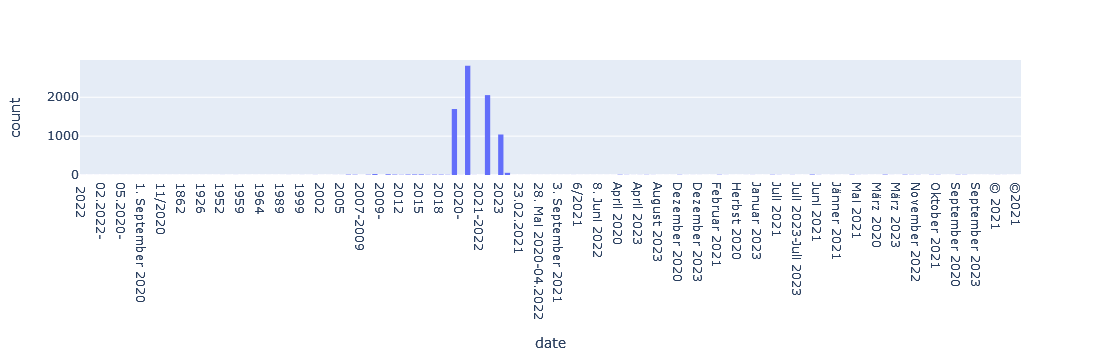

In [160]:
fig2 = px.histogram(df, x="date", barmode='group')
fig2.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig2.show()

In [161]:
df.loc[:, 'date'] = df['date'].str.replace(r'-+$', '', regex=True)

In [162]:
df.loc[:, 'date'] = df['date'].str[-4:]

In [163]:
#df.loc[df["DATE"] == "20ka"]

In [164]:
df.loc[:, 'date'] = df['date'].str.replace("20ka", "2020")

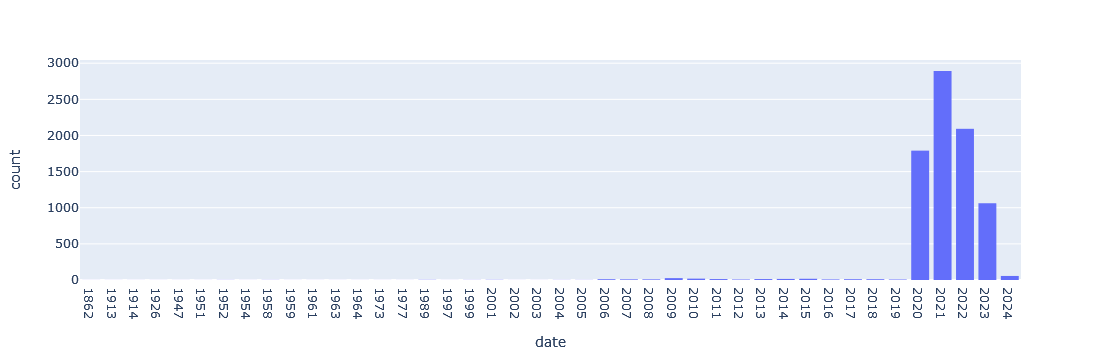

In [165]:
fig3 = px.histogram(df, x="date", barmode='group')
fig3.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig3.show()

In [166]:
df

,idn,title,date,lang,urn,title_clean
0,1285990005,"2020 das jahr, das die welt veränderte der ame...",2024,ger,N/A,2020 jahr welt veränderte amerikanische soziol...
1,1317002237,ängste der allgemeinbevölkerung in zeiten der ...,2024,ger,urn:nbn:de:bsz:14-qucosa2-890970,ängste allgemeinbevölkerung zeiten covid-19-pa...
2,1319076106,aufbau eines key account managements in der to...,2024,ger,urn:nbn:de:101:1-2024021302301350289147,aufbau key account managements tourismusbranch...
4,1315575361,auswirkungen der corona-pandemie auf die ausbi...,2024,ger,urn:nbn:de:101:1-2024011102383134159187,auswirkungen corona-pandemie ausbildung gesund...
5,131701071X,auswirkungen der covid-19-pandemie auf die pri...,2024,ger,urn:nbn:de:bsz:16-heidok-342525,auswirkungen covid-19-pandemie primärversorgun...
...,...,...,...,...,...,...
11363,129882589X,"zwei nachbarländer, eine pandemie",2023,ger,urn:nbn:de:101:1-2023080821170040558967,zwei nachbarländer pandemie
11364,1232892661,zwei runden gehen an corona – aber die urologi...,2021,ger,urn:nbn:de:101:1-2021050520504432857162,zwei runden gehen corona urologie ende gewinnen
11365,1307057543,zwischen arbeitserleichterung und de-professio...,2023,ger,urn:nbn:de:101:1-2023102409011131884864,arbeitserleichterung de-professionalisierungsg...
11366,1241532591,zwischen pandemie und wahlkampf: verhältnismäß...,2021,ger,urn:nbn:de:101:1-2021092021390437649681,pandemie wahlkampf verhältnismäßigkeit wahren


Zwischenspeichern des Ergebnisses: 

In [167]:
df.to_hdf("df_prep.h5", key="df")